# Modelo de visión artificial para verificar la edad en la venta de alcohol en Good Seed

# Descripción 
A la cadena de supermercados Good Seed le gustaría explorar si la ciencia de los datos puede ayudarle a cumplir con las leyes sobre el alcohol, al asegurarse de no vender alcohol a personas menores de edad. Te piden que hagas esa evaluación, así que, cuando te pongas a trabajar, ten en cuenta lo siguiente:
- Las tiendas están equipadas con cámaras en el área de pago, las cuales se activan cuando una persona está comprando alcohol.
- Los métodos de visión artificial se pueden usar para determinar la edad de una persona a partir de una foto.
- La tarea, entonces, es construir y evaluar un modelo para verificar la edad de las personas.  

Para empezar a trabajar en la tarea, tendrás un conjunto de fotografías de personas que indican su edad.

## Inicialización de librerías

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import seaborn as sns
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Carga los datos

El conjunto de datos se almacena en la carpeta `/datasets/faces/` 
- La carpeta `final_files` con 7600 fotos 
- El archivo `labels.csv` con etiquetas, con dos columnas: `file_name` y `real_age` 
Dado que el número de archivos de imágenes es bastante elevado, se recomienda evitar leerlos todos a la vez, ya que esto consumiría muchos recursos computacionales. Te recomendamos crear un generador con ImageDataGenerator. Este método se explicó en el capítulo 3, lección 7 de este curso.

El archivo de etiqueta se puede cargar como un archivo CSV habitual.

In [2]:
# Carga del dataframe con la edad de las fotos
labels = pd.read_csv('/datasets/faces/labels.csv')
labels

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


In [3]:
# Leer las imagenes por lotes de 32
train_datagen = ImageDataGenerator(rescale=1/255.)

train_datagen_flow = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    seed=12345
)

Found 7591 validated image filenames.


## EDA

In [4]:
# Visualizar los datos
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [5]:
# Verificar si hay valores ausentes, cantidad de datos. 
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [6]:
# Estádistica descriptiva
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [7]:
# Verificar duplicados
labels.duplicated().sum()

0

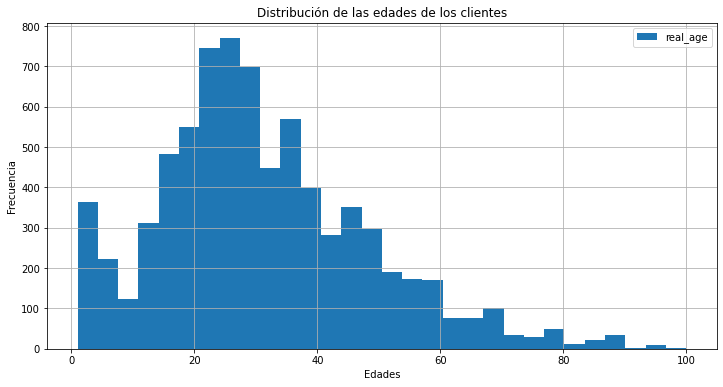

In [11]:
# Distribución de las edades
labels.plot(kind='hist', bins=30, grid=True, figsize=(12, 6))
plt.title('Distribución de las edades de los clientes')
plt.xlabel('Edades')
plt.ylabel('Frecuencia')
plt.show()

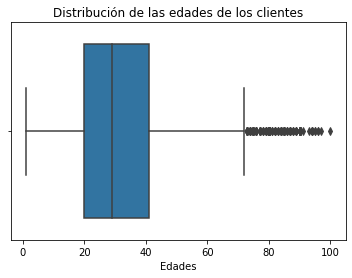

In [13]:
# Boxplot de las edades
sns.boxplot(x=labels['real_age'])
plt.title('Distribución de las edades de los clientes')
plt.xlabel('Edades')
plt.show()

In [14]:
# Ver cuantos ejemplares tienen tienen mas de 60 años.
labels[labels['real_age']==60].count()

file_name    75
real_age     75
dtype: int64

**Notas grales.:**
- La edad va de 1 a 100 años. 
- El 50% de los datos estan entre los 20-41 años. 
- El 25% de los datos estan entre los 41 y 100 años.
- No hay datos ausentes. 
- Labels contiene el nombre de la imagen y la edad. 
- No hay duplicados
- 7591 datos.

**Notas de las distribución:**
- La distribución esta sesgada hacia la derecha.
- Hay presencia de valores atípicos.

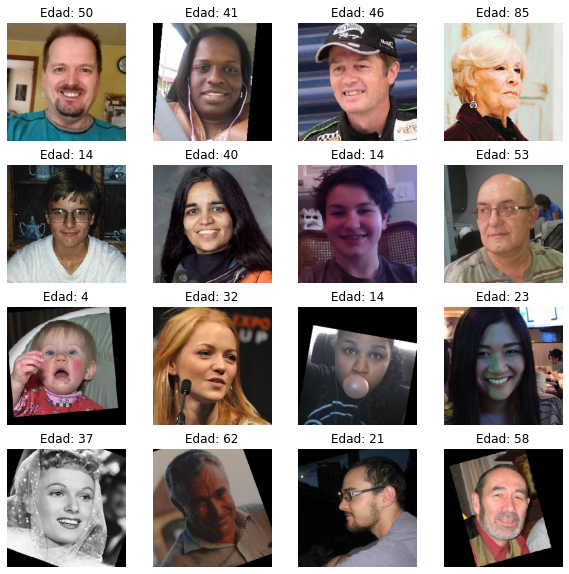

In [15]:
# Mostrar 16 imagenes con su edad
batch_images, batch_labels = train_datagen_flow.next()
batch_size = batch_images.shape[0]

plt.figure(figsize=(10, 10))
for img in range(16):
    plt.subplot(4, 4, img+1)
    plt.imshow(batch_images[img])
    plt.title(f'Edad: {batch_labels[img]}')
    plt.axis('off')
plt.show()

**Nota:**
- Existen imagenes de hombres, mujeres, niños, adultos. Muy variado.
- Algunas imagenes estan rotadas.
- Hay imagenes a color y en blanco y negro.
- 224 pixeles de ancho y alto para cada imagen. 

### Conclusiones

- Es un problema de regresión lineal. Se va a predecir la edad de 1 a 100 años. 
- Creo que las imagenes pueden ser rotadas y volteadas sin problema. 
- Probablemente se tenga que aumentar el número de imagenes, sobretodo para las edades mas avanzadas, las cuales contienen pocos ejemplares.
- Se recomienda investigar si este grupo (60+ años) es recurrente en la tienda. De ser así es necesario obtener mas imagenes de las edades correspondientes. 
- La salida solo tendra un valor. 

## Modelado

Se definieron funciones necesarias para entranar el modelo en la plataforma GPU. Se creo un solo scrip que contienen todas junto con la sección de inicialización.

In [16]:
def load_train(path):
    
    """
    Carga la parte de entrenamiento del conjunto de datos desde la ruta.
    """
    # Cargar el dataframe con el objetivo (edad) y el nombre de las imagenes
    labels = pd.read_csv('/datasets/faces/labels.csv')
    
    # Inicializar el generador
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255.,
        vertical_flip=True,
        horizontal_flip=True,
        rotation_range=90
    )
    
    # Generar un lote
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345
    )
    
    return train_datagen_flow

In [17]:
def load_test(path):
    
    """
    Carga la parte de validación/prueba del conjunto de datos desde la ruta
    """
    # Cargar el dataframe con el objetivo (edad) y el nombre de las imagenes
    labels = pd.read_csv('/datasets/faces/labels.csv')

    # Inicializar el generador
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.)

    # Generar un lote
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345
    )

    return test_datagen_flow

In [18]:
def create_model(input_shape):
    
    """
    Define el modelo
    """
    # Utilizar ResNet50 ya entrenada
    backbone = ResNet50(
        input_shape=input_shape, weights='imagenet', include_top=False
    )

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))
    optimizer = Adam(lr=0.0001)
    model.compile(
        optimizer=optimizer,
        loss='mean_absolute_error',
        metrics=['mae']
    )
    return model

In [19]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Entrena el modelo dados los parámetros
    """
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data) 
        
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2,
    )

    return model

## Prepara el script para ejecutarlo en la plataforma GPU

Una vez definido las funciones necesarias, se redacta un script para la plataforma GPU, se descarga a través del menú "File|Open..." (Archivo|Abrir) y cargarlo más tarde para ejecutarlo en la plataforma GPU.

In [20]:
# prepara un script para ejecutarlo en la plataforma GPU

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam


def load_train(path):
    
    # Cargar el dataframe con el objetivo (edad) y el nombre de las imagenes
    labels = pd.read_csv('/datasets/faces/labels.csv')
    
    # Inicializar el generador
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255.,
        vertical_flip=True,
        horizontal_flip=True,
        rotation_range=90
    )
    
    # Generar un lote
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345
    )
    
    return train_datagen_flow

def load_test(path):
    
    # Cargar el dataframe con el objetivo (edad) y el nombre de las imagenes
    labels = pd.read_csv('/datasets/faces/labels.csv')

    # Inicializar el generador
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.)

    # Generar un lote
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345
    )

    return test_datagen_flow
    
def create_model(input_shape):
    
    # Utilizar ResNet50 ya entrenada
    backbone = ResNet50(
        input_shape=input_shape, weights='imagenet', include_top=False
    )

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))
    optimizer = Adam(lr=0.0001)
    model.compile(
        optimizer=optimizer,
        loss='mean_absolute_error',
        metrics=['mae']
    )
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data) 
        
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2,
    )

    return model
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Resultdo del entrenamiento y prueba. 

Se coloca el resultado de la plataforma GPU como una celda de markdown.

Solución
2024-02-06 21:48:59.690076: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2024-02-06 21:48:59.691929: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2024-02-06 21:49:01.295252: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2024-02-06 21:49:01.429245: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-06 21:49:01.429452: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2024-02-06 21:49:01.429498: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2024-02-06 21:49:01.429546: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-02-06 21:49:01.497595: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2024-02-06 21:49:01.521820: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2024-02-06 21:49:01.678425: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2024-02-06 21:49:01.693487: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2024-02-06 21:49:01.693592: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2024-02-06 21:49:01.693749: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-06 21:49:01.693987: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-06 21:49:01.694133: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2024-02-06 21:49:01.694482: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2024-02-06 21:49:01.725472: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300000000 Hz
2024-02-06 21:49:01.729067: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x37860d0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-02-06 21:49:01.729103: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-02-06 21:49:01.873784: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-06 21:49:01.874069: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x15c4720 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-06 21:49:01.874091: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-16GB, Compute Capability 7.0
2024-02-06 21:49:01.874355: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-06 21:49:01.874589: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2024-02-06 21:49:01.874649: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2024-02-06 21:49:01.874677: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-02-06 21:49:01.874718: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2024-02-06 21:49:01.874752: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2024-02-06 21:49:01.874785: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2024-02-06 21:49:01.874819: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2024-02-06 21:49:01.874841: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2024-02-06 21:49:01.874937: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-06 21:49:01.875199: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-06 21:49:01.875381: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2024-02-06 21:49:01.876592: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2024-02-06 21:49:03.847744: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2024-02-06 21:49:03.847794: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2024-02-06 21:49:03.847804: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2024-02-06 21:49:03.849152: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-06 21:49:03.849399: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-06 21:49:03.849588: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-02-06 21:49:03.849634: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 14988 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:1e.0, compute capability: 7.0)
Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

    8192/94765736 [..............................] - ETA: 1s
10240000/94765736 [==>...........................] - ETA: 0s
21520384/94765736 [=====>........................] - ETA: 0s
32833536/94765736 [=========>....................] - ETA: 0s
44441600/94765736 [=============>................] - ETA: 0s
55984128/94765736 [================>.............] - ETA: 0s
67534848/94765736 [====================>.........] - ETA: 0s
78823424/94765736 [=======================>......] - ETA: 0s
90341376/94765736 [===========================>..] - ETA: 0s
94773248/94765736 [==============================] - 0s 0us/step
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/20
2024-02-06 21:49:19.944719: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-02-06 21:49:21.102084: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 112s - loss: 13.0815 - mae: 13.0825 - val_loss: 22.7873 - val_mae: 22.7901
Epoch 2/20
178/178 - 92s - loss: 9.1249 - mae: 9.1243 - val_loss: 22.0328 - val_mae: 22.0354
Epoch 3/20
178/178 - 92s - loss: 8.4955 - mae: 8.4961 - val_loss: 21.5078 - val_mae: 21.4838
Epoch 4/20
178/178 - 92s - loss: 8.1105 - mae: 8.1102 - val_loss: 13.9052 - val_mae: 13.8940
Epoch 5/20
178/178 - 92s - loss: 7.7800 - mae: 7.7802 - val_loss: 11.3894 - val_mae: 11.3812
Epoch 6/20
178/178 - 92s - loss: 7.5358 - mae: 7.5361 - val_loss: 8.7062 - val_mae: 8.7273
Epoch 7/20
178/178 - 92s - loss: 7.2579 - mae: 7.2581 - val_loss: 7.6009 - val_mae: 7.5851
Epoch 8/20
178/178 - 92s - loss: 7.0507 - mae: 7.0506 - val_loss: 7.6675 - val_mae: 7.6751
Epoch 9/20
178/178 - 95s - loss: 7.0731 - mae: 7.0734 - val_loss: 8.9765 - val_mae: 9.0177
Epoch 10/20
178/178 - 94s - loss: 6.7773 - mae: 6.7776 - val_loss: 7.3899 - val_mae: 7.4080
Epoch 11/20
178/178 - 95s - loss: 6.7062 - mae: 6.7064 - val_loss: 7.2499 - val_mae: 7.2907
Epoch 12/20
178/178 - 94s - loss: 6.4422 - mae: 6.4423 - val_loss: 8.7230 - val_mae: 8.7397
Epoch 13/20
178/178 - 94s - loss: 6.2354 - mae: 6.2355 - val_loss: 8.6630 - val_mae: 8.6516
Epoch 14/20
178/178 - 94s - loss: 6.1978 - mae: 6.1980 - val_loss: 7.0151 - val_mae: 7.0242
Epoch 15/20
178/178 - 95s - loss: 5.9915 - mae: 5.9919 - val_loss: 7.5689 - val_mae: 7.5654
Epoch 16/20
178/178 - 95s - loss: 5.9094 - mae: 5.9097 - val_loss: 8.7801 - val_mae: 8.7477
Epoch 17/20
178/178 - 94s - loss: 5.7437 - mae: 5.7440 - val_loss: 7.1838 - val_mae: 7.2172
Epoch 18/20
178/178 - 94s - loss: 5.7513 - mae: 5.7518 - val_loss: 7.0890 - val_mae: 7.1055
Epoch 19/20
178/178 - 93s - loss: 5.6271 - mae: 5.6273 - val_loss: 7.3161 - val_mae: 7.3543
Epoch 20/20
178/178 - 92s - loss: 5.4205 - mae: 5.4207 - val_loss: 7.5445 - val_mae: 7.5288
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 7.5445 - mae: 7.5288
Test MAE: 7.5288

## Conclusiones

- Se obtuvo un EAM de 7.5288, menos al propuesto (8), algunas epocas dieron hasta 7.10. Probablemente entrenarlo durante mayor tiempo hubiese dado un mejor resultado.
- Cumple la función de predecir la edad adecuadamente. 
- Rotar y voltear las imagenes funciona para mejorar el modelo.
- Podría usarse para identificar productos en la tienda. Por ejemplo frutas y verduras evitando que la persona encargada tenga que memorizar los ID's. 
- Quiza en un futuro se pueda implementar un sistema de recomendación. Si puede reconocer los clientes en vez de la edad, se ajustaría no solamente la recomendación por edad sino por gustos. 